# 2. Multiclass classification
**Goal:** predict the type of delay for delayed flights  

**Target variables:** 
- `CARRIER_DELAY`
- `WEATHER_DELAY`
- `NAS_DELAY`
- `SECURITY_DELAY`
- `LATE_AIRCRAFT_DELAY`  

**Notes**:  

Train this model on a dataset containing delayed flights. We might have unbalanced representation between.  classes, check class representation in the data

**Steps**:
1. Pick evaluation metrics
2. Spot check different algos
3. Tune hyperparameters using grid search on 2-3 selected algos
4. Compare them based on the selected metrics

## Step 1. Pick evaluation metrics
Performance measures for multi-class classification  
**F1 score**  
**Accuracy**  
**Precision-Recall AUC**

## Step 2. Spot check different algos (using K-Folds on sample data)

### Step 2.1 Spot check regular algorythms

- Naive algorythm (used as a baseline model):  
Predict the majority class for all

- Linear algorythms:  
Logistic Regression  
LDA  
Support Vector Machines
Naive Bayes

- Non linear algos:  
k-Nearest Neighbors  

- Ensemble algorythms:  
Random forest  
Stochastic Gradient Boosting  
 *Optional: custom ensemble*


### Step 2.2 Spot check imbalanced classification algos. Use those techniques on the ML algos to see if it improves performance

- Data sampling  
Oversampler and Undersampler method: SMOTE combined with RandomUnderSampler on the training datasets in this step [Article on how to perform SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

- Probability tuning (custom threshold) on the algos that can give probabilities as outputs  
Logistic Regression 
LDA 

- *Optional: Try a [calibration algo on the predicted prbobabilities](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)*



In [55]:
import numpy as np
import pandas as pd

In [56]:
# data 
data = pd.read_csv('db_multiclass_sample.csv', index_col = 0)
print(data.shape)
print(data.columns)

data_pca = pd.read_csv('db_multiclass_pca_sample.csv', index_col = 0)
print(data_pca.shape)
print(data_pca.columns)

(3451, 18)
Index(['branded_code_share', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'air_time', 'distance', 'fl_month',
       'fl_day_of_week', 'fl_type', 'state_travel_type', 'm_hist_dep_delay',
       'med_hist_dep_delay', 'm_hist_arr_delay', 'med_hist_arr_delay',
       'origin_cat', 'dest_cat', 'mkt_op_combo_cat', 'delay_type'],
      dtype='object')
(1000000, 13)
Index(['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10',
       'pc11', 'pc12', 'delay_type'],
      dtype='object')


In [75]:
y = data.delay_type
X = data.drop('delay_type', axis = 1)
print(y.shape)
print(X.shape)

data_pca_small = data_pca.sample(10000) ###smaller sample
y_pca_small = data_pca_small.delay_type
X_pca_small = data_pca_small.drop('delay_type', axis = 1)
print(y_pca_small.shape)
print(X_pca_small.shape)

(3451,)
(3451, 17)
(10000,)
(10000, 12)


### Step 2.1 Spot Check Algos

In [58]:
# this function creates two dataframe outputs: AVG scoring per model and STD scoring per model
# make sure you import the models outside of this function and that the scorings are supported by them
def perform_cross_validate(models, X, y, scoring, n_folds, plot = False):
    
    # import cross validate
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import numpy as np
    
    # create dataframe
    results_mean = pd.DataFrame(columns = list(models.keys()), index=list(scoring))
    results_std = pd.DataFrame(columns = list(models.keys()),  index=list(scoring))
    

    # perform cross validate and store desults in the dataframe
    for key in models:
        model_name = key
        model = models[key]  # this is the model's placeholder
        cv = cross_validate(estimator=model, X=X, y=y, cv=n_folds, scoring=scoring)
    
        # adds values for each scoring in the dataframes
        results_mean[model_name] = [cv['test_'+scoring[i]].mean() for i in range(len(scoring))]
        results_std[model_name] = [cv['test_'+scoring[i]].std() for i in range(len(scoring))]
        
        
    if plot:
        #setup
        to_plot = {0:311, 1:312, 2:313, 3:314, 4:315, 5:316}
        import matplotlib.pyplot as plt
        %matplotlib inline
        from matplotlib.pylab import rcParams
        rcParams['figure.figsize'] = 12, 10
        
        # plot
        for i, score in enumerate(scoring):
            plt.subplot(to_plot[i])
            plt.bar(list(results_mean.columns),  results_mean.iloc[i].values)
            plt.title(f'Plot for: {score}')
            
    return results_mean, results_std

In [68]:
# import models to try
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# params
models = {
    'Dummy Classifier': DummyClassifier(strategy = "most_frequent"), \
    'Logistic Regression': LogisticRegression(max_iter = 10000), \
    'LDA': LinearDiscriminantAnalysis(), \
    'Random Forest': RandomForestClassifier(), \
    'Gradient Boosting': GradientBoostingClassifier(), \
    'XGBoost': xgb.XGBClassifier(scale_pos_weight=100) \
    }

scoring = ('accuracy', 'f1_weighted')

### 3451 datapoints sample from db_multiclass_sample.csv, 3 folds

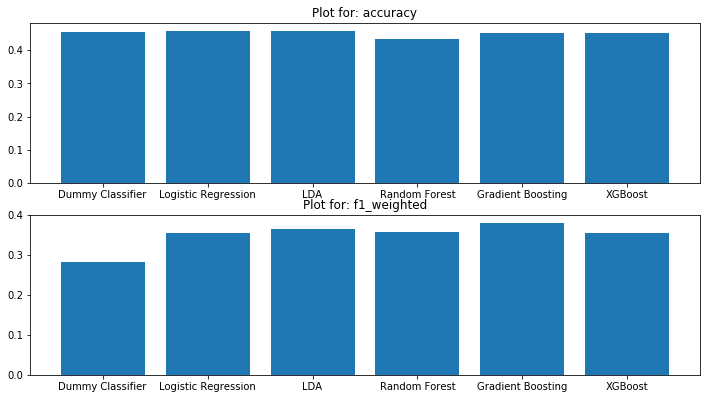

In [70]:
results_mean, results_std = perform_cross_validate(models=models, X=X, y=y, scoring=scoring, n_folds=3, plot=True)

### 10 000 datapoints from db_multiclass_pca_sample.csvsample, 5 folds

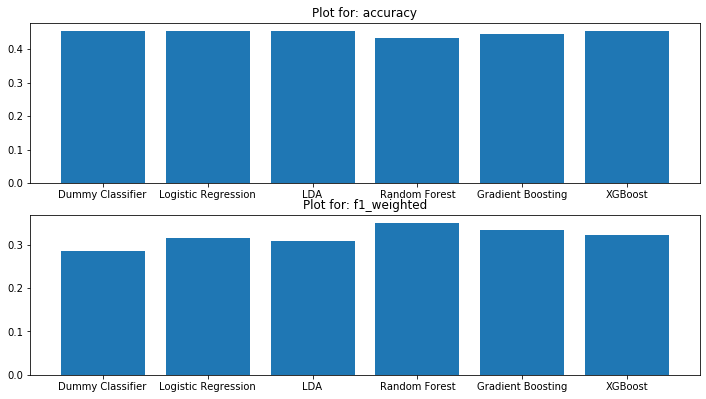

In [77]:
results_mean, results_std = perform_cross_validate(models=models, X=X_pca_small, y=y_pca_small, scoring=scoring, n_folds=3, plot=True)

### Try models individually

In [33]:
# split data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score  
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = \
train_test_split(X, y, train_size=0.80, random_state=101)

In [37]:
# Logistic regressor
from sklearn.linear_model import LogisticRegression # model

model = LogisticRegression(max_iter=10000) # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
#auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f'{accuracy} \n{f1}')

0.4515195369030391 
0.34984367064115035


In [40]:
#OveVSRestClassifier
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression(penalty= 'l2')) # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
#auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f'{accuracy} \n{f1}')

0.447178002894356 
0.3402268699523125


In [53]:
# Random forest

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
#auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f'{accuracy} \n{f1}')

0.42981186685962375 
0.35803742656299514


In [54]:
# XGBoost
import xgboost as xgb

model = xgb.XGBClassifier(gamma=0.5, n_jobs=-1) # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
#auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f'{accuracy} \n{f1}')

0.4544138929088278 
0.3636717624736192


## Step 3. Hyperparameter tuning
Use Grid Search to tune the selected algo (on the whole dataframe?)